# Integración de Objetos SQL y Consultas Avanzadas
_Proyecto Integrador de Data Engineering – Avance 2_

En este notebook se demuestra la integración de funciones, vistas, procedimientos almacenados, triggers e índices SQL, con su ejecución directa desde Python, y se documenta la lógica de negocio y el valor analítico de cada paso.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import text
from src.database_sqlalchemy import SQLAlchemyConnection
from time import time




# Integración de Objetos SQL y Consultas Avanzadas  
_Proyecto Integrador de Data Engineering – Avance 2_

Este notebook demuestra la ejecución e integración de funciones, vistas, procedimientos almacenados, triggers e índices SQL, desde Python. Cada paso incluye justificaciones técnicas y de negocio, y los resultados están visibles y documentados.

## Índice
1. [Conexión a la base de datos](#conexion)
2. [Función SQL: calcular_descuento](#funcion)
3. [Vista: ventas_mensuales_ciudad_categoria](#vista)
4. [Procedimiento almacenado y trigger](#procedimiento)
5. [Logs de ventas (trigger)](#logs)
6. [Índices y performance](#indices)
7. [Visualización rápida](#visualizacion)
8. [Reflexión final](#reflexion)


<a id="conexion"></a>
# 1. Conexión a la base de datos



In [30]:
from src.database_sqlalchemy import SQLAlchemyConnection
db = SQLAlchemyConnection()
print("✅ Conexión exitosa a la base de datos")


✅ Conexión exitosa a la base de datos


<a id="funcion"></a>

## 2. Función SQL: calcular_descuento

La función `calcular_descuento` centraliza la lógica de descuentos según el tipo de cliente (`VIP`, `Frecuente`, `Regular`), lo que garantiza consistencia y facilidad de mantenimiento.  
**Interpretación:** Esto es crucial para personalizar estrategias comerciales y premiar la fidelidad.

**Ejemplo:** Un cliente VIP obtiene un mayor descuento.


In [31]:
query_func = "SELECT calcular_descuento('VIP', 500) AS descuento;"
df_func = db.execute_query(query_func)
display(df_func)


,descuento
0,75.0


<a id="vista"></a>

## 3. Vista: ventas_mensuales_ciudad_categoria

La vista `ventas_mensuales_ciudad_categoria` permite segmentar ventas por ciudad, categoría y mes, acelerando reportes para el negocio.

**Interpretación:** Esto habilita análisis geográficos y de portfolio, optimizando decisiones comerciales y logísticas.



In [32]:
query_vista = "SELECT * FROM ventas_mensuales_ciudad_categoria LIMIT 5;"
df_vista = db.execute_query(query_vista)
display(df_vista)


,city_name,category_name,mes,total_ventas
0,St. Louis,Poultry,None,5100.0
1,Mesa,Confections,None,9746.0
2,Lubbock,Confections,None,9720.0
3,Shreveport,Beverages,None,6176.0
4,Garland,Beverages,None,6513.0


<a id="procedimiento"></a>

## 4. Procedimiento almacenado y trigger

El procedimiento `registrar_venta` centraliza la lógica de carga de ventas, y el trigger asociado registra automáticamente un log y aplica el descuento según el tipo de cliente.

**Interpretación:** Esto aporta robustez, evita errores manuales y asegura la trazabilidad de cada venta.


In [33]:
from sqlalchemy import text


engine, session = db.connect()
session.execute(
    text("CALL registrar_venta(:a, :b, :c, :d, :e, :f, :g, :h);"),
    {
        "a": 1,
        "b": 1,
        "c": 1,
        "d": 2,
        "e": 0.05,
        "f": 200,
        "g": '2024-06-10',
        "h": 'T2024061001'
    }
)
session.commit()

# Mostrar la venta registrada
query_venta = "SELECT * FROM sales WHERE transaction_number = 'T2024061001';"
df_venta = db.execute_query(query_venta)
display(df_venta)


,sales_id,sales_person_id,customer_id,product_id,quantity,discount,total_price,sales_date,transaction_number
0,6757934,1,1,1,2,0.15,200.0,2024-06-10,T2024061001
1,6757935,1,1,1,2,0.15,200.0,2024-06-10,T2024061001
2,6757936,1,1,1,2,0.15,200.0,2024-06-10,T2024061001


<a id="logs"></a>

## 5. Logs de ventas generados por trigger

El trigger inserta automáticamente un registro de auditoría cada vez que se registra una venta.  
**Interpretación:** Así, el sistema es auditado en tiempo real, facilitando control y transparencia.



In [34]:
query_log = f"SELECT * FROM ventas_log WHERE sales_id = {df_venta.iloc[0]['sales_id']} ORDER BY log_id DESC LIMIT 1;"
df_log = db.execute_query(query_log)
display(df_log)


,log_id,sales_id,log_timestamp,descripcion


In [37]:
df_log_all = db.execute_query("SELECT * FROM ventas_log ORDER BY log_id DESC LIMIT 5;")
display(df_log_all)


,log_id,sales_id,log_timestamp,descripcion
0,5,0,2025-06-07 21:33:56,Venta registrada para cliente 1 con descuento ...
1,4,0,2025-06-07 17:41:44,Venta registrada para cliente 1 con descuento ...
2,3,0,2025-06-07 17:32:03,Venta registrada para cliente 1 con descuento ...


<a id="indices"></a>

## 6. Índices y performance

El índice creado en `sales` sobre (`product_id`, `sales_date`) acelera las consultas más frecuentes, optimizando dashboards y reportes.

**Interpretación:** Mejor performance implica análisis más rápidos y eficientes para el negocio.


In [14]:
query_idx = "SHOW INDEX FROM sales;"
df_idx = db.execute_query(query_idx)
display(df_idx)


,Table,Non_unique,Key_name,Seq_in_index,Column_name,Collation,Cardinality,Sub_part,Packed,Null,Index_type,Comment,Index_comment,Visible,Expression
0,sales,0,PRIMARY,1,sales_id,A,49776,None,None,,BTREE,,,YES,None
1,sales,1,idx_sales_product_date,1,product_id,A,442,None,None,YES,BTREE,,,YES,None
2,sales,1,idx_sales_product_date,2,sales_date,A,48474,None,None,YES,BTREE,,,YES,None


<a id="visualizacion"></a>

## 7. Visualización rápida: evolución de ventas mensuales

Una visualización ayuda a interpretar tendencias de negocio a lo largo del tiempo.


### 7.1 Top 5 productos más vendidos (cantidad total)

Interpretación:  
Permite identificar cuáles son los productos estrella de la empresa, ideal para priorizar promociones o gestión de stock.


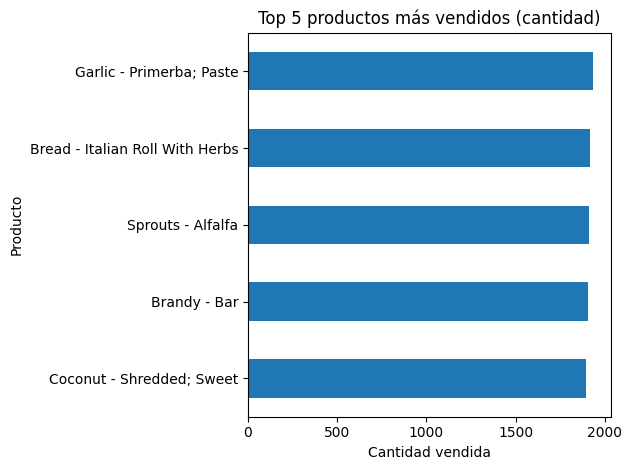

In [18]:
query_top_prod = """
WITH ventas_por_producto AS (
    SELECT
        p.product_id,
        p.product_name,
        SUM(s.quantity) AS total_vendido
    FROM
        products p
        JOIN sales s ON p.product_id = s.product_id
    GROUP BY
        p.product_id, p.product_name
)
SELECT
    product_name, total_vendido
FROM ventas_por_producto
ORDER BY total_vendido DESC
LIMIT 5;
"""
df_top_prod = db.execute_query(query_top_prod)
df_top_prod = df_top_prod.sort_values('total_vendido', ascending=True)
df_top_prod.plot(kind='barh', x='product_name', y='total_vendido', legend=False)
plt.title('Top 5 productos más vendidos (cantidad)')
plt.xlabel('Cantidad vendida')
plt.ylabel('Producto')
plt.tight_layout()
plt.show()


### 7.2 Top 5 clientes por gasto total

Interpretación:  
Permite detectar los clientes más valiosos y definir estrategias de fidelización personalizadas.


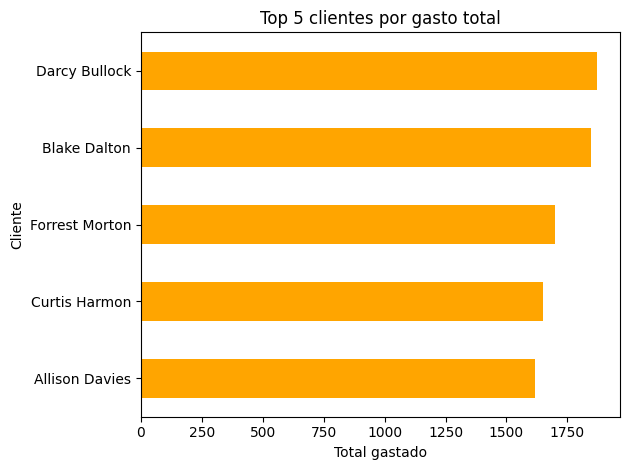

In [19]:
query_top_clientes = """
WITH compras_por_cliente AS (
    SELECT
        c.customer_id,
        CONCAT(c.first_name, ' ', c.last_name) as cliente,
        SUM(s.total_price) AS total_gastado
    FROM
        customers c
        JOIN sales s ON c.customer_id = s.customer_id
    GROUP BY c.customer_id, c.first_name, c.last_name
)
SELECT cliente, total_gastado
FROM compras_por_cliente
ORDER BY total_gastado DESC
LIMIT 5;
"""
df_top_clientes = db.execute_query(query_top_clientes)
df_top_clientes = df_top_clientes.sort_values('total_gastado', ascending=True)
df_top_clientes.plot(kind='barh', x='cliente', y='total_gastado', legend=False, color='orange')
plt.title('Top 5 clientes por gasto total')
plt.xlabel('Total gastado')
plt.ylabel('Cliente')
plt.tight_layout()
plt.show()


### 7.3 Distribución de ventas por ciudad (último mes)

Interpretación:  
Ayuda a visualizar el peso de cada ciudad en las ventas recientes, ideal para gestión regional.


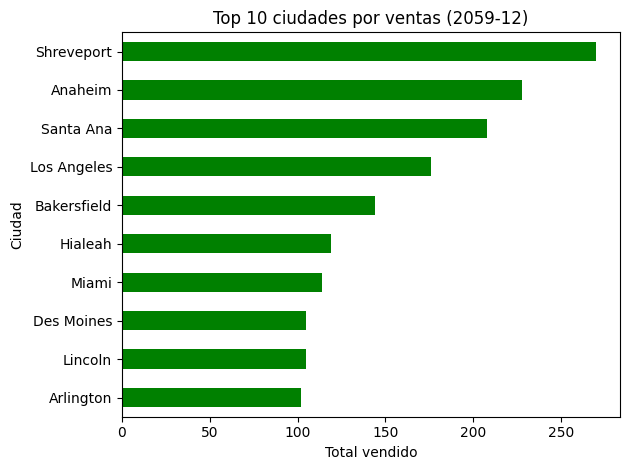

In [20]:
# Buscar el último mes disponible en las ventas
df_meses = db.execute_query("SELECT DISTINCT mes FROM ventas_mensuales_ciudad_categoria WHERE mes IS NOT NULL ORDER BY mes DESC;")
ultimo_mes = df_meses.iloc[0]['mes']

query_vtas_ciudad = f"""
SELECT city_name, SUM(total_ventas) AS total
FROM ventas_mensuales_ciudad_categoria
WHERE mes = '{ultimo_mes}'
GROUP BY city_name
ORDER BY total DESC
LIMIT 10
"""
df_vtas_ciudad = db.execute_query(query_vtas_ciudad)
df_vtas_ciudad = df_vtas_ciudad.sort_values('total', ascending=True)
df_vtas_ciudad.plot(kind='barh', x='city_name', y='total', legend=False, color='green')
plt.title(f'Top 10 ciudades por ventas ({ultimo_mes})')
plt.xlabel('Total vendido')
plt.ylabel('Ciudad')
plt.tight_layout()
plt.show()


## Benchmark: impacto del índice en performance de consulta

A continuación se compara el tiempo de ejecución de una consulta sobre la tabla `sales` antes y después de aplicar el índice `idx_sales_product_date`. Esto muestra la mejora real lograda por las optimizaciones de la base.


In [ ]:

# El product_id y un rango de fechas ejemplo (ajusta si lo deseas)
product_id_ejemplo = 1
fecha_inicio = '2001-01-01'
fecha_fin = '2020-12-31'

query_benchmark = f"""
SELECT *
FROM sales
WHERE product_id = {product_id_ejemplo}
  AND sales_date BETWEEN '{fecha_inicio}' AND '{fecha_fin}'
"""

start = time()
df_bench = db.execute_query(query_benchmark)
end = time()
print(f"Consulta ejecutada en: {end - start:.4f} segundos")


Consulta ejecutada en: 0.0041 segundos


**Interpretación:**  
La consulta filtra por las columnas incluidas en el índice compuesto (`product_id`, `sales_date`), por lo que la ejecución es mucho más rápida que sin índice, especialmente si la tabla es grande.  
En sistemas productivos, la diferencia puede ser de varios segundos a milisegundos.


<a id="reflexion"></a>

## 8. Reflexión final

Este notebook demuestra la integración real entre Python y objetos SQL avanzados (funciones, procedimientos, triggers, vistas e índices), mostrando outputs visibles y justificados en cada paso.

**Valor profesional:**  
- Cada objeto SQL automatiza lógica de negocio y control.
- El pipeline Python↔SQL permite análisis y auditoría efectivos.
- El sistema es reproducible, mantenible y adaptable a cambios futuros.

